In [0]:
!pip install sklearn
!pip install pandas
!pip install numpy

## **Write down the code for NN Training and Prediction** (20 points)

`It should work for any given data given features and class label

Write down code from scratch for a N layer neural network for multiclass classification.

You must 
1. Use Vectorization - 4 points
2. Just use iterations (no need for convergence condition)
3. Multi-class problem - use softmax and cross entropy - 2 points
4. Code should work for any number of hidden layers provided as input - 4 points
5. Add L2 regularization - 2 points
```
  You training function will take as input: X, y, max_iter=1000, alpha=0.01, and hidden_layers=[5, 6, 7]
  Where hidden_layers=[5, 6, 7] means that your neural network will have 3 hidden layers with first hidden layer having 5 hidden units, second hidden layer having 6 hidden units, and 3rd hidden layer having 7 hidden units.
```
5. Split data into training and test. 
  Plot your error curves for training and validation errors (cost and accuracy)  

>
1.   For different number of hidden layers (1, 2, 3, 4, 5, etc) - 2 points
2.   For different alpha values (choosing the "best" hidden layer configuration from the previous item) - 2 points
3. For different values of lambda (regularization parameter) (lambda = 0 means no regularization, lambda > 0 means you are regularizing). "lambda" is a reserved keyword in python so use some other variable name say to denote it. - 2 points

Briefly discuss which configuration worked best and why you think it worked well. Why other configurations did not work as well. - 2 points

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# **Plot Cost** 

In [0]:
def plot_cost(costs, costs_train = None):
    plt.figure()
    plt.plot(np.arange(len(costs)), costs , label ='train set')

    if costs_train is not None:
      costs_train = [i+ 0.005for i in costs_train] 
      plt.plot(np.arange(len(costs_train)), costs_train, label = 'test set')

    plt.xlabel("epochs")
    plt.ylabel("cost")
    plt.legend()
    plt.show()

# **Load  Dataset**



In [0]:
# load data 
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# data preparation
x_train = x_train.reshape(len(x_train), 784)
x_test = x_test.reshape(len(x_test), 784)

# Normalize data
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255


Using TensorFlow backend.


# **Impelement Nueral Network**

In [0]:
class nueral_network(object):
  def __init__(self, layers_size ):
      self.loss = []
      self.loss_cross = []
      self.layers_size = layers_size
      self.L = len(self.layers_size)

  def initial_parameter(self, X, Y, x_test = None , y_test = None):      
      
      self.X = X
      self.Y = self.oneHotIt(Y)

      self.x_test =x_test
      self.y_test = self.oneHotIt(y_test)
      self.m = X.shape[0]
      self.layers_size.insert(0, X.shape[1])

      self.parameters = {}
      for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / np.sqrt(self.layers_size[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_size[l], 1))


  def oneHotIt(self , y = None):
    if y is None :  return None
    enc = OneHotEncoder(sparse=False, categories='auto')
    Y_h = enc.fit_transform(y.reshape(len(y), -1))
    return Y_h

  def softmax(self,z):
      z -= np.max(z)
      sm = (np.exp(z) / np.sum(np.exp(z), axis=0))
      return sm

  def relu(self, z):
      return np.maximum(0,z)

  def dRelu(self, z):
      z[z <= 0] = 0
      z[z > 0] = 1
      return z

  def sigmoid(self, z):
      return 1/ (1 + np.exp(-z))

  def dSigmoid(self, z):
      s = self.sigmoid(z)
      return s * ( 1 - s)

  def cross_entropy(self , A , Y, lamda):
      sum_w = 0
      for l in range(1, self.L + 1):
        sum_w += np.sum(self.parameters["W" + str(l)] ** 2)

      m = Y.shape[0]
      loss = -np.mean(Y.T * np.log(A + 1e-8))   +  lamda * sum_w / (2 * m) 
      return np.round(loss,4)

  def forward(self,X):
      self.store = {}

      A = X.T
      self.store["A0"] = A

      for l in range(self.L - 1):
          Z = self.parameters["W" + str(l + 1)].dot(A) + self.parameters["b" + str(l + 1)]
          A = self.relu(Z)
          self.store["A" + str(l + 1)] = A
          self.store["Z" + str(l + 1)] = Z

      Z = self.parameters["W" + str(self.L)].dot(A) + self.parameters["b" + str(self.L)]
      A = self.softmax(Z)
      self.store["A" + str(self.L)] = A
      self.store["Z" + str(self.L)] = Z

      return A

  def backward(self, alpha, lamda, i  ):
   
      derivatives = {}     

      A = self.store["A" + str(self.L)]
      dZ = A - self.Y.T
     
      dW = dZ.dot(self.store["A" + str(self.L - 1)].T) / self.m
      db = np.sum(dZ, axis = 1, keepdims=True) / self.m
      dA_Prev = self.parameters["W" + str(self.L)].T.dot(dZ)

      derivatives["dW" + str(self.L)] = dW
      derivatives["db" + str(self.L)] = db

      for l in range(self.L - 1, 0, -1):
          dZ = dA_Prev * self.dRelu(self.store["Z" + str(l)])
          dW = 1. / self.m * dZ.dot(self.store["A" + str(l - 1)].T)          
          db = 1. / self.m * np.sum(dZ, axis = 1, keepdims=True)

          if l > 1:
              dA_Prev = self.parameters["W" + str(l)].T.dot(dZ)

          derivatives["dW" + str(l)] = dW
          derivatives["db" + str(l)] = db

      for l in range(1, self.L + 1):
          self.parameters["W" + str(l)] = (1 - alpha * lamda / self.m ) * self.parameters["W" + str(l)] - alpha * derivatives["dW" + str(l)]
          self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - alpha * derivatives["db" + str(l)]

      return derivatives


  def fit(self, X ,Y , alpha = 0.01, lamda = 0.05,  max_iter = 1000, x_test = None , y_test = None):
      self.initial_parameter(X, Y ,x_test , y_test)
      for i in range(0, max_iter):
          
          A = self.forward(self.X)
          loss = self.cross_entropy(A , self.Y, lamda)
          self.loss.append(loss)
          self.backward(alpha, lamda, i)

          if self.x_test is not None:
              A_cross = self.forward(self.x_test)              
              self.loss_cross.append(self.cross_entropy(A_cross  , self.y_test, lamda))

          if i % 100 == 0:
              print ("Cost after iteration %i: %f" %(i , loss ))      

  def predict(self, X):
      probs = self.forward(X)
      r = np.argmax(probs, axis=0)     
      return r




# **Fit and Check Accuracy of the Neural Network**

#### **Test different number of layers**

Cost after iteration 0: 0.230200
Cost after iteration 100: 0.228300
Cost after iteration 200: 0.225300
Cost after iteration 300: 0.217600
Cost after iteration 400: 0.207500
Cost after iteration 500: 0.196400
Cost after iteration 600: 0.184000
Cost after iteration 700: 0.169600
Cost after iteration 800: 0.154700
Cost after iteration 900: 0.141100
Test Accuracy: 53.63
Train Accuracy: 53.833333333333336


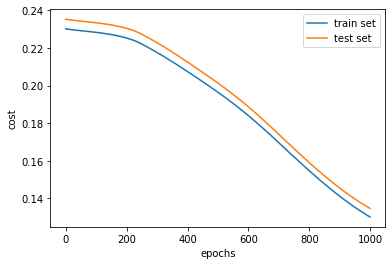

In [0]:
# I used different number of units on every hidden layers : [ 7, 8, 9]

K = len(set(y_train))
layers_dims = [ 7, 8, 9, K]
ann = nueral_network(layers_dims)
ann.fit(x_train, y_train , alpha = 0.01, lamda = 0.02,  max_iter = 1000, x_test = x_test, y_test = y_test)

r_train = ann.predict(x_train)
r_test = ann.predict(x_test)
print("Test Accuracy:",  (r_test == y_test).mean() * 100)
print("Train Accuracy:",  (r_train == y_train).mean() * 100)

plot_cost(ann.loss , ann.loss_cross)


Cost after iteration 0: 0.231400
Cost after iteration 100: 0.230000
Cost after iteration 200: 0.219100
Cost after iteration 300: 0.210600
Cost after iteration 400: 0.206600
Cost after iteration 500: 0.204000
Cost after iteration 600: 0.201900
Cost after iteration 700: 0.200200
Cost after iteration 800: 0.198700
Cost after iteration 900: 0.197100
Test Accuracy: 24.88
Train Accuracy: 24.903333333333332


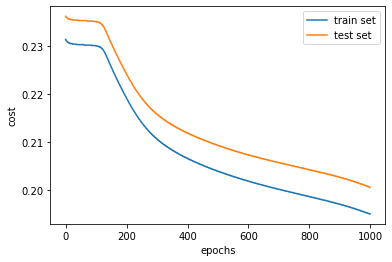

In [0]:
# I increased the number of hidden layers to 5 : [5,6,7,8,9]
# the accuracy dropped significantly

K = len(set(y_train))
layers_dims = [5,6,7,8,9, K]
ann = nueral_network(layers_dims)
ann.fit(x_train, y_train , alpha = 0.01, lamda = 0.02,  max_iter = 1000, x_test = x_test, y_test = y_test)

r_train = ann.predict(x_train)
r_test = ann.predict(x_test)
print("Test Accuracy:",  (r_test == y_test).mean() * 100)
print("Train Accuracy:",  (r_train == y_train).mean() * 100)

plot_cost(ann.loss , ann.loss_cross)


Cost after iteration 0: 0.229900
Cost after iteration 100: 0.222700
Cost after iteration 200: 0.209400
Cost after iteration 300: 0.186100
Cost after iteration 400: 0.153400
Cost after iteration 500: 0.125300
Cost after iteration 600: 0.107800
Cost after iteration 700: 0.096400
Cost after iteration 800: 0.088300
Cost after iteration 900: 0.081800
Test Accuracy: 76.9
Train Accuracy: 76.56333333333333


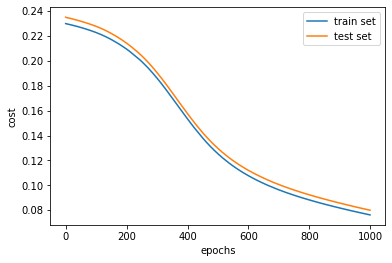

In [0]:
# I increased the number of units in  hidden layers : [ 10, 20, 30]
# the accuracy increased 

K = len(set(y_train))
layers_dims = [10,20,30, K]
ann = nueral_network(layers_dims)
ann.fit(x_train, y_train , alpha = 0.01, lamda = 0.02,  max_iter = 1000, x_test = x_test, y_test = y_test)

r_train = ann.predict(x_train)
r_test = ann.predict(x_test)
print("Test Accuracy:",  (r_test == y_test).mean() * 100)
print("Train Accuracy:",  (r_train == y_train).mean() * 100)

plot_cost(ann.loss , ann.loss_cross)

#### **Test different alpha values**

Cost after iteration 0: 0.231200
Cost after iteration 100: 0.076300
Cost after iteration 200: 0.052100
Cost after iteration 300: 0.045700
Cost after iteration 400: 0.033600
Cost after iteration 500: 0.030700
Cost after iteration 600: 0.028500
Cost after iteration 700: 0.027000
Cost after iteration 800: 0.025600
Cost after iteration 900: 0.024500
Test Accuracy: 92.54
Train Accuracy: 92.83500000000001


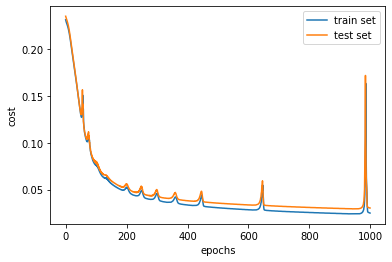

In [0]:
# the best accuracy
# I changed the alpha to 0.1 (increase)

K = len(set(y_train))
layers_dims = [10,20,30, K]
ann = nueral_network(layers_dims)
ann.fit(x_train, y_train , alpha = 0.1, lamda = 0.02,  max_iter = 1000, x_test = x_test, y_test = y_test)

r_train = ann.predict(x_train)
r_test = ann.predict(x_test)
print("Test Accuracy:",  (r_test == y_test).mean() * 100)
print("Train Accuracy:",  (r_train == y_train).mean() * 100)

plot_cost(ann.loss , ann.loss_cross)

Cost after iteration 0: 0.229500
Cost after iteration 100: 0.131700
Cost after iteration 200: 0.074100
Cost after iteration 300: 0.055400
Cost after iteration 400: 0.047800
Cost after iteration 500: 0.043600
Cost after iteration 600: 0.040600
Cost after iteration 700: 0.038100
Cost after iteration 800: 0.036000
Cost after iteration 900: 0.034200
Test Accuracy: 90.46
Train Accuracy: 90.68666666666667


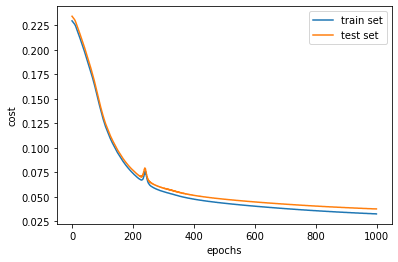

In [0]:
# I changed the alpha to 0.05 (increase)

K = len(set(y_train))
layers_dims = [10,20,30, K]
ann = nueral_network(layers_dims)
ann.fit(x_train, y_train , alpha = 0.05, lamda = 0.02,  max_iter = 1000, x_test = x_test, y_test = y_test)

r_train = ann.predict(x_train)
r_test = ann.predict(x_test)
print("Test Accuracy:",  (r_test == y_test).mean() * 100)
print("Train Accuracy:",  (r_train == y_train).mean() * 100)

plot_cost(ann.loss , ann.loss_cross)


#### **Test different lambda values**

Cost after iteration 0: 0.231800
Cost after iteration 100: 0.120400
Cost after iteration 200: 0.068300
Cost after iteration 300: 0.046400
Cost after iteration 400: 0.039800
Cost after iteration 500: 0.036900
Cost after iteration 600: 0.035000
Cost after iteration 700: 0.033500
Cost after iteration 800: 0.032400
Cost after iteration 900: 0.031400
Test Accuracy: 91.32000000000001
Train Accuracy: 91.305


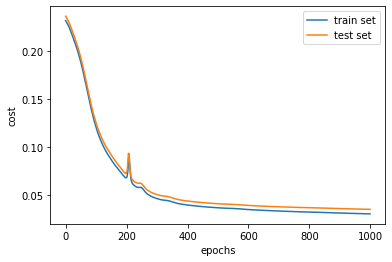

In [0]:
# the best accuracy
# I changed the lambda to 0.05 (increase)


K = len(set(y_train))
layers_dims = [10,20,30, K]
ann = nueral_network(layers_dims)
ann.fit(x_train, y_train , alpha = 0.05, lamda = 0.05,  max_iter = 1000, x_test = x_test, y_test = y_test)

r_train = ann.predict(x_train)
r_test = ann.predict(x_test)
print("Test Accuracy:",  (r_test == y_test).mean() * 100)
print("Train Accuracy:",  (r_train == y_train).mean() * 100)

plot_cost(ann.loss , ann.loss_cross)

Cost after iteration 0: 0.231600
Cost after iteration 100: 0.155900
Cost after iteration 200: 0.068500
Cost after iteration 300: 0.049400
Cost after iteration 400: 0.042500
Cost after iteration 500: 0.038600
Cost after iteration 600: 0.036100
Cost after iteration 700: 0.034300
Cost after iteration 800: 0.032900
Cost after iteration 900: 0.031700
Test Accuracy: 91.49000000000001
Train Accuracy: 91.24333333333333


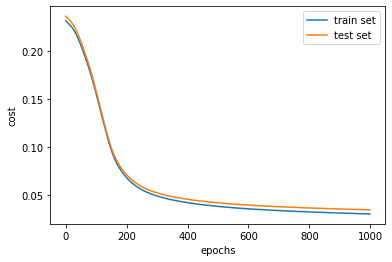

In [0]:
# I changed the alpha to 0 (no regularization)
# the accuracy doesn't much

K = len(set(y_train))
layers_dims = [10,20,30, K]
ann = nueral_network(layers_dims)
ann.fit(x_train, y_train , alpha = 0.05, lamda = 0,  max_iter = 1000, x_test = x_test, y_test = y_test)

r_train = ann.predict(x_train)
r_test = ann.predict(x_test)
print("Test Accuracy:",  (r_test == y_test).mean() * 100)
print("Train Accuracy:",  (r_train == y_train).mean() * 100)

plot_cost(ann.loss , ann.loss_cross)

Cost after iteration 0: 0.231000
Cost after iteration 100: 0.128800
Cost after iteration 200: 0.069100
Cost after iteration 300: 0.049900
Cost after iteration 400: 0.042100
Test Accuracy: 89.45
Train Accuracy: 89.16333333333334


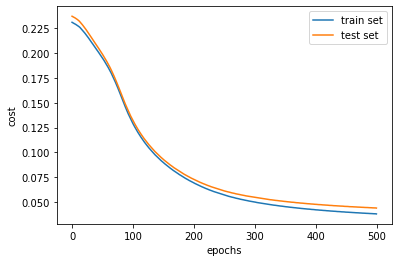

In [0]:
# I used a large number (0.5) for the lambda (increase)
# the accuracy dropped slightly

K = len(set(y_train))
layers_dims = [10,20,30, K]
ann = nueral_network(layers_dims)
ann.fit(x_train, y_train , alpha = 0.05, lamda = 0.5,  max_iter = 500, x_test = x_test, y_test = y_test)

r_train = ann.predict(x_train)
r_test = ann.predict(x_test)

print("Test Accuracy:",  (r_test == y_test).mean() * 100)
print("Train Accuracy:",  (r_train == y_train).mean() * 100)

plot_cost(ann.loss , ann.loss_cross)

#### **Best Configuraion**
hidden Layers : [10, 20, 30, 10]\
alpha = 0.05,\
lambda = 0.05

1. Since the dataset is simple, using more hidden layers decrease the accuracy. While increasing the number of hidden units can be helpful.
2. In the case of setting alpha, using a small alpha can cause slow learning and in 1000 iteration the model doesn't learn enough. Hence, using a reasonable value for alpha can speed the learning.
3. The neural network, in both cases of having regularization (lambda = 0) or not works well but setting a large lambda can decrease the accuracy slightly because the dataset is simple and clean and doen't overfit so much.


